# Data exploration

**Main objective**

In this notebook, the main objectives are: 
* Explore the distribution of parsed skills and job information.
* Analyze the distribution of the number of skills per candidate and identify outliers.
* Examine the distributions of hard and soft skills.

In [22]:
%load_ext autoreload 
%autoreload 2
import matplotlib.pyplot as plt
import polars as pl

from hiring_cv_bias.config import (
    CLEANED_SKILLS,
    HARD_SOFT_SKILLS,
)
from hiring_cv_bias.exploration.utils import plot_boxplot, plot_distribution_bar
from hiring_cv_bias.exploration.visualize import (
    plot_skills_frequency,
    plot_skills_per_category,
    plot_top_skills_for_job_title,
)
from hiring_cv_bias.utils import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
cv_skills = load_data(CLEANED_SKILLS)
cv_skills.head(10)

CANDIDATE_ID,Skill,Skill_Type
i64,str,str
7990324,"""Computer Literacy""","""IT_Skill"""
7990324,"""Dental Assistant (m/f)""","""Job_title"""
7990324,"""General Labourer (other) (m/f)""","""Job_title"""
7990324,"""Intern (m/f)""","""Job_title"""
7990324,"""Italian""","""Language_Skill"""
7974050,"""Adobe Dreamweaver""","""IT_Skill"""
7974050,"""ECDL""","""IT_Skill"""
7974050,"""HTML""","""IT_Skill"""
7974050,"""Microsoft Access""","""IT_Skill"""


### Skill Extraction by Category

The bar chart displays the total number of skills extracted for each **skill_type**:

- **Professional_Skill**: ~68,000 occurrences — the most frequently identified category.  
- **Job_title**: ~23,000 occurrences.  
- **IT_Skill**: ~22,000 occurrences.  
- **Language_Skill**: ~13,000 occurrences.  
- **DRIVERSLIC**: ~2,500 occurrences — the least common category.  

In [24]:
skill_counts = (
    cv_skills.group_by("Skill_Type")
    .agg(pl.count("Skill_Type").alias("count"))
    .sort("count", descending=True)
)
skill_counts

Skill_Type,count
str,u32
"""Professional_Skill""",67873
"""Job_title""",23169
"""IT_Skill""",22415
"""Language_Skill""",13075
"""DRIVERSLIC""",2366


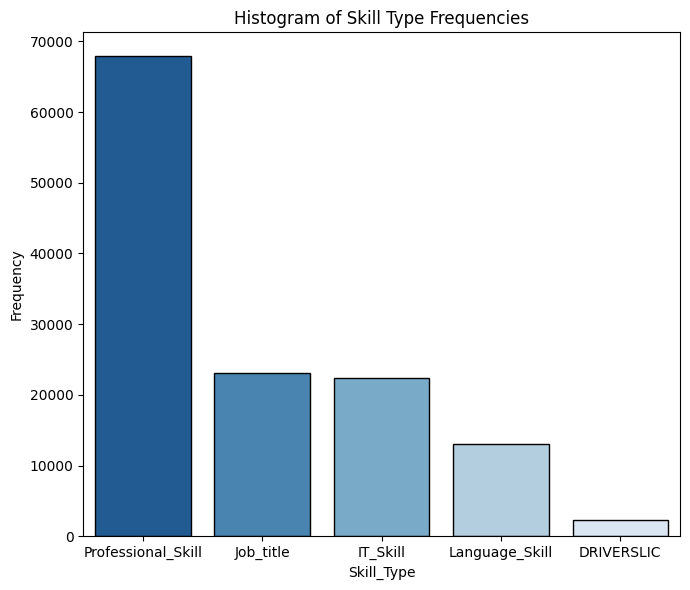

In [25]:
plot_skills_frequency(cv_skills)

### Top N Skills by Category

The `plot_skills_per_category` function can be used to visualize the most frequent skills within any given skill category. It:

1. Filters the `cv_skills` DataFrame by the chosen `skill_type`.  
2. Computes the frequency of each individual skill in that category.  
3. Plots the top _n_ skills by their occurrence count.  

With the parameters below, we are displaying the **top 10** most common skills for the **Job_title** category.

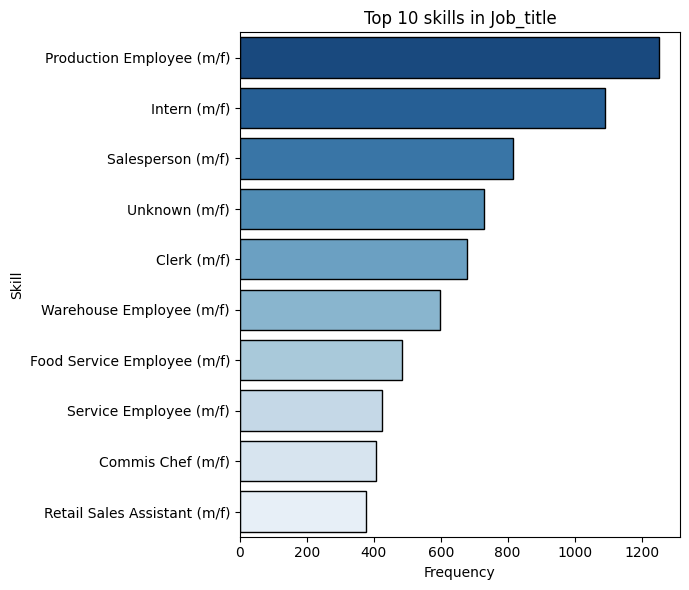

In [26]:
skill_pd = plot_skills_per_category(cv_skills, "Job_title", top_n=10)

#### Top N Skills for a Given Job Title

This function shows the most common `<skills>` for candidates who have a specific `<job_title>`. It simply:

1. Picks out all candidates with the chosen job title.  
2. Collects their skills of **the specified category**.  
3. Counts how often each skill appears.  
4. Plots the top _n_ skills by frequency.

With the parameters below, we are displaying the **top 10** most frequent **IT skills** among candidates with **“Commis Chef (m/f)”** job experience.

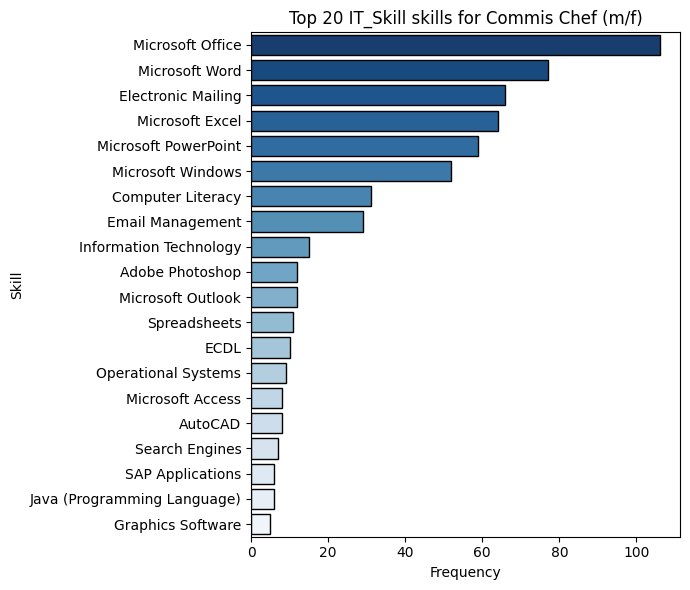

In [27]:
plot_top_skills_for_job_title(cv_skills, "Commis Chef (m/f)", "IT_Skill", top_n=20)

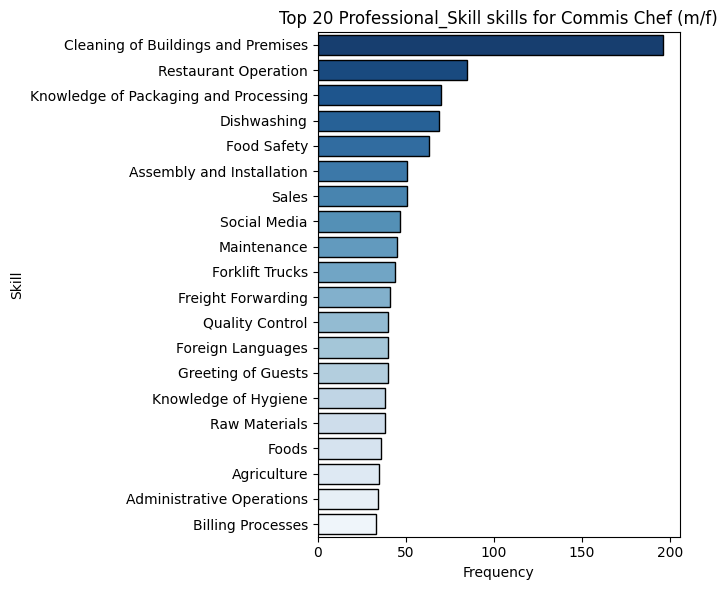

In [28]:
plot_top_skills_for_job_title(
    cv_skills, "Commis Chef (m/f)", "Professional_Skill", top_n=20
)

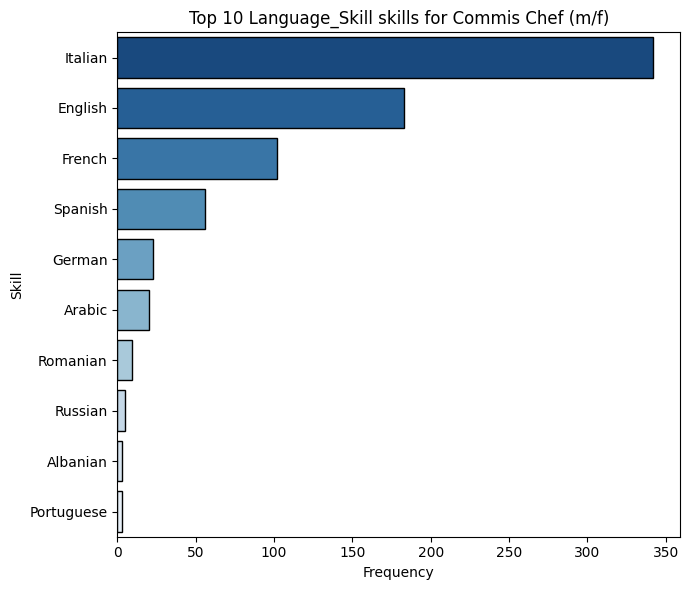

In [29]:
plot_top_skills_for_job_title(
    cv_skills, "Commis Chef (m/f)", "Language_Skill", top_n=10
)

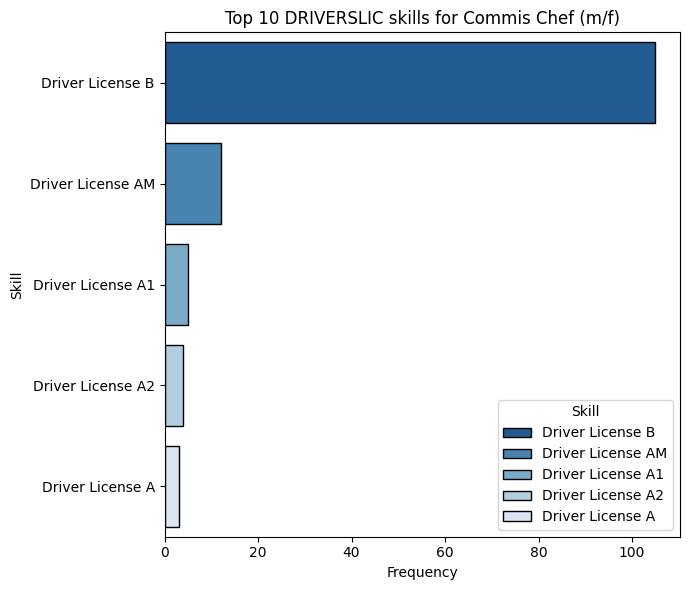

In [30]:
plot_top_skills_for_job_title(cv_skills, "Commis Chef (m/f)", "DRIVERSLIC", top_n=10)

### Counting Skills per Candidate

In this step, we aim to:

- **Visualize the distribution** of the number of skills extracted per candidate.
- **Spot and investigate outliers**, candidates who list an unusually high number of skills.

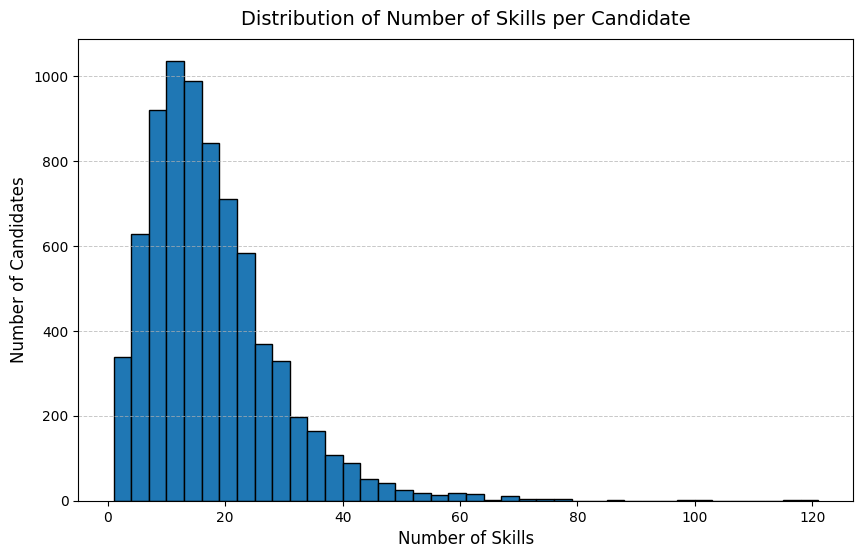

In [31]:
skill_counts = cv_skills.group_by("CANDIDATE_ID").len()

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(skill_counts["len"], bins=40, edgecolor="black")
ax.set_title("Distribution of Number of Skills per Candidate", fontsize=14, pad=10)
ax.set_xlabel("Number of Skills", fontsize=12)
ax.set_ylabel("Number of Candidates", fontsize=12)
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

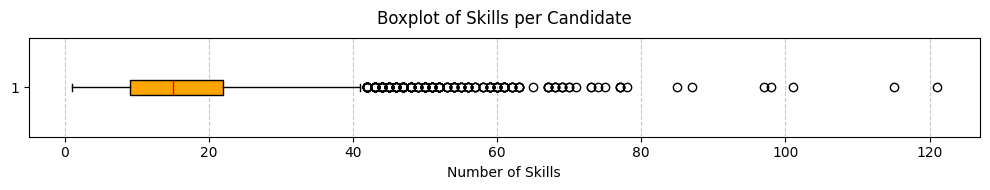

In [32]:
plot_boxplot(
    data=skill_counts["len"],
    labels=None,
    title="Boxplot of Skills per Candidate",
    xlabel="Number of Skills",
    colors=["orange"],
    figsize=(10, 2),
)

### Hard vs Soft Skills Analysis


In this section, we investigate the distribution of **hard** and **soft** skills extracted from the candidate CVs. (column `Professional_Skill`)

> The logic used to label each skill as *hard* or *soft* is documented in the `hard_soft_labelling.ipynb` notebook.

Here we present:
- **Total distribution** of hard vs soft skills across all candidates.
- **Distribution per candidate**: number of hard vs soft skills per individual, to highlight representation gaps.

In [33]:
hard_soft_skills = load_data(HARD_SOFT_SKILLS)
hard_soft_skills

Skill,label
str,str
"""V-Ray""","""Hard"""
"""Demographics""","""Hard"""
"""Angel Investing""","""Hard"""
"""Confined Spaces""","""Hard"""
"""Target Market Selection""","""Unknown"""
…,…
"""Emergency Management""","""Soft"""
"""Search Engine Optimization""","""Hard"""
"""Personal Branding""","""Soft"""


In [34]:
cv_skills_with_label = cv_skills.join(hard_soft_skills, on="Skill")
cv_skills_with_label

CANDIDATE_ID,Skill,Skill_Type,label
i64,str,str,str
7974050,"""Billing Processes""","""Professional_Skill""","""Hard"""
7974050,"""Databases""","""Professional_Skill""","""Hard"""
7974050,"""Polling""","""Professional_Skill""","""Hard"""
7965670,"""Accounting""","""Professional_Skill""","""Hard"""
7965670,"""Administrative Operations""","""Professional_Skill""","""Soft"""
…,…,…,…
18233,"""Knowledge of Finance""","""Professional_Skill""","""Hard"""
18233,"""Maintenance""","""Professional_Skill""","""Hard"""
18233,"""Multi-Level Marketing""","""Professional_Skill""","""Unknown"""


* **Hard skills** dominate the dataset, accounting for roughly ~75% of all skills extracted from the CVs.

* **Soft skills** are markedly under represented, at about one skill in five.

> A small remainder is classified as “Unknown” terms that did not match either taxonomy, highlighting the presence of noise in the parsed skills data. (see `hard_soft_labelling.ipynb`)

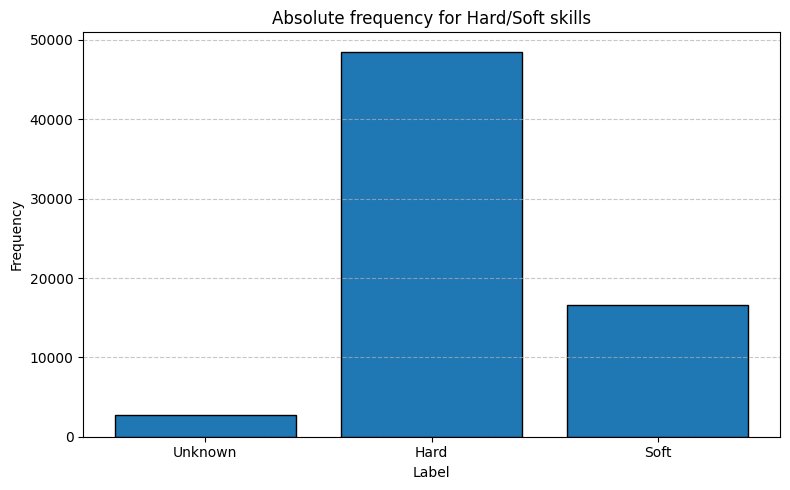

In [35]:
counts = cv_skills_with_label["label"].value_counts()
plot_distribution_bar(
    counts,
    "label",
    "count",
    "Label",
    "Frequency",
    "Absolute frequency for Hard/Soft skills",
)

In [36]:
per_cand = (
    cv_skills_with_label.group_by(["CANDIDATE_ID", "label"])
    .agg(pl.len())
    .pivot(
        index="CANDIDATE_ID",
        on="label",
        values="len",
    )
    .fill_null(0)
    .with_columns(
        [
            (pl.col("Hard") + pl.col("Soft") + pl.col("Unknown").fill_null(0)).alias(
                "total"
            ),
        ]
    )
)

As we can see from the analysis below:

* **Most applicants (about two thirds)** mention at least one hard **and** one soft skill, suggesting reasonably balanced self presentation.

* **One third list exclusively hard skills**; they highlight only technical competence.

* **Soft skill only CVs** are extremely rare; almost nobody relies on soft skills without pairing them with technical ones.

A negligible fraction provide no skills at all, indicating either very short resumes or parsing errors that deserve inspection.

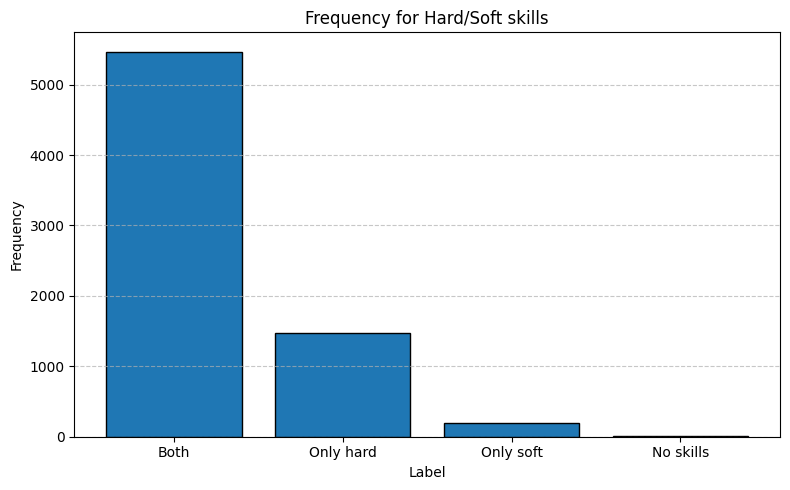

In [37]:
cats = per_cand.with_columns(
    [
        pl.when((pl.col("Hard") == 0) & (pl.col("Soft") == 0))
        .then(pl.lit("No skills"))
        .when((pl.col("Hard") > 0) & (pl.col("Soft") == 0))
        .then(pl.lit("Only hard"))
        .when((pl.col("Hard") == 0) & (pl.col("Soft") > 0))
        .then(pl.lit("Only soft"))
        .otherwise(pl.lit("Both"))
        .alias("category")
    ]
)

counts = cats.group_by("category").len().sort("len", descending=True)

plot_distribution_bar(
    counts, "category", "len", "Label", "Frequency", "Frequency for Hard/Soft skills"
)

In [38]:
per_cand = per_cand.with_columns(
    (pl.col("Hard") / pl.col("total")).alias("hard_share"),
)
per_cand

CANDIDATE_ID,Hard,Soft,Unknown,total,hard_share
i64,u32,u32,u32,u32,f64
7131635,3,0,0,3,1.0
7498567,1,2,0,3,0.333333
159887,4,2,1,7,0.571429
6068054,5,8,2,15,0.333333
6648801,12,0,1,13,0.923077
…,…,…,…,…,…
158112,1,0,0,1,1.0
7268636,1,0,0,1,1.0
6801841,7,0,0,7,1.0


The chart shows how technical competences (**hard skills**) are distributed across each candidate.

For each one of them we calculate the **hard skill share**, the ratio between the number of hard skills and the total number of skills, listed (hard + soft + any unknown items) and we plot all of these percentages in a histogram.

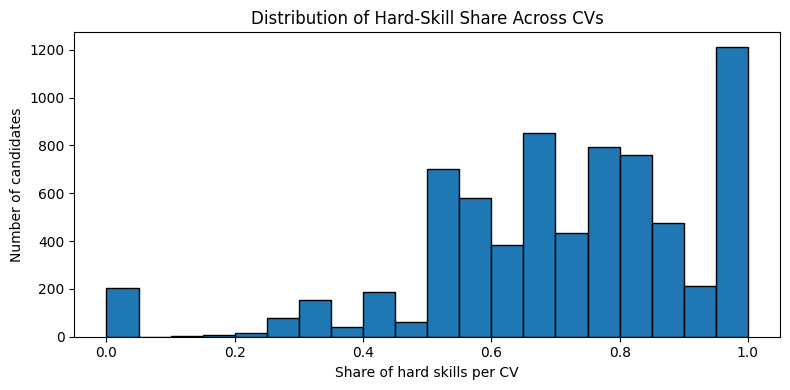

In [39]:
data = per_cand["hard_share"].to_numpy()

plt.figure(figsize=(8, 4))
plt.hist(data, bins=20, edgecolor="black")
plt.xlabel("Share of hard skills per CV")
plt.ylabel("Number of candidates")
plt.title("Distribution of Hard-Skill Share Across CVs")
plt.tight_layout()
plt.show()

The box plot highlights several outliers. (20+ hard skills / 10+ soft skills)

Such counts are well beyond the typical range and **may** indicate parsing errors (e.g bullet points misclassified as skills, the same skill split into multiple tokens ecc).
These outliers should be reviewed manually to confirm whether they reflect genuine, unusually rich profiles or artefacts produced by the parsing pipeline.

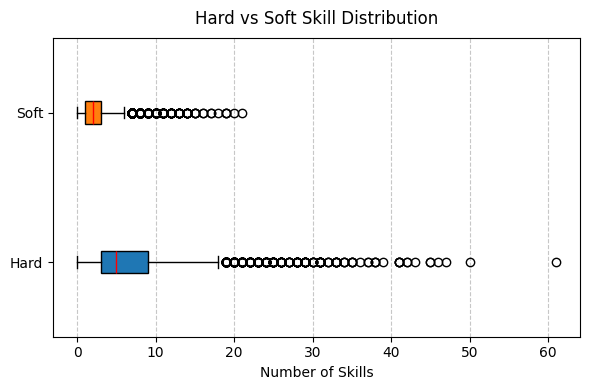

In [40]:
plot_boxplot(
    data=[per_cand["Hard"], per_cand["Soft"]],
    labels=["Hard", "Soft"],
    title="Hard vs Soft Skill Distribution",
    xlabel="Number of Skills",
    colors=["#1f77b4", "#ff7f0e"],
    figsize=(6, 4),
)